<a href="https://colab.research.google.com/github/kevin-weis/Hit_Song_Science/blob/main/HitPredictionModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install spotipy

     |████████████████████████████████| 61kB 3.0MB/s 
     |████████████████████████████████| 143kB 29.6MB/s 
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split

from scipy.stats import loguniform
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.model_selection import GridSearchCV

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials #To access authorised Spotify data
client_id = 'b0a721515fbe4aa689f4685942d43527'
client_secret = 'c788d362a41645fc9d30369195d66d65'
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager, requests_timeout=100) #spotify object to access API

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
df = pd.read_csv("/content/drive/MyDrive/HitSongScience/hitprediction.csv", index_col=[0])

In [4]:
df.head()

danceability  energy  key  ...  acousticness  instrumentalness  hits
0         0.681  0.5500    7  ...       0.85500          0.000000     0
1         0.573  0.8300    9  ...       0.00418          0.000344     0
2         0.552  0.5970    0  ...       0.23500          0.000000     0
3         0.598  0.7510    4  ...       0.07450          0.000000     0
4         0.443  0.0921   11  ...       0.98100          0.000036     0

[5 rows x 15 columns]

In [5]:
df['hits'].value_counts()

0    503495
1      2773
Name: hits, dtype: int64

In [6]:
df = df.set_index('id')
df.head()

danceability  ...  hits
id                                                  ...      
spotify:track:2FpNT3Xc8zs0geV5HkVefh         0.681  ...     0
spotify:track:50BBHm3TZDpJW9gPfzeI9W         0.573  ...     0
spotify:track:7cg1ixMs3NweK4vZdjrHDI         0.552  ...     0
spotify:track:4WtO3Mc0jgqRx3lCcXTNVx         0.598  ...     0
spotify:track:78JWcR18EW13NAy4597qK1         0.443  ...     0

[5 rows x 14 columns]

In [7]:
df_hits = df[df['hits'] == 1]
df_hits.head()

danceability  ...  hits
id                                                  ...      
spotify:track:4gTMIyJJlSuB5BOhbMri6B         0.791  ...     1
spotify:track:6xP5TGWu1GBEHjMBmHRbjT         0.611  ...     1
spotify:track:5BEEQXb9tOhjuSQZ0drIaD         0.914  ...     1
spotify:track:0jWm0VyD8p3MrSInczpows         0.875  ...     1
spotify:track:4yHFxB8kzzeuNvoouR8N0N         0.774  ...     1

[5 rows x 14 columns]

In [8]:
df_flops = df[df['hits'] == 0]
df_flops.head()

danceability  ...  hits
id                                                  ...      
spotify:track:2FpNT3Xc8zs0geV5HkVefh         0.681  ...     0
spotify:track:50BBHm3TZDpJW9gPfzeI9W         0.573  ...     0
spotify:track:7cg1ixMs3NweK4vZdjrHDI         0.552  ...     0
spotify:track:4WtO3Mc0jgqRx3lCcXTNVx         0.598  ...     0
spotify:track:78JWcR18EW13NAy4597qK1         0.443  ...     0

[5 rows x 14 columns]

In [ ]:
subset_flops = df_flops.sample(n=50000, replace=False, random_state=42, axis=0)
subset_flops.shape

(50000, 14)

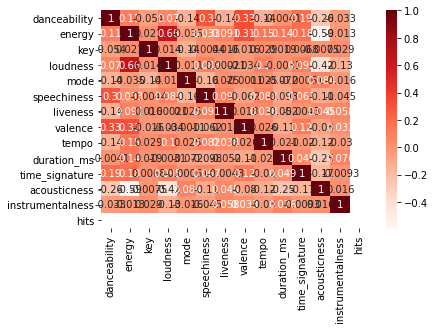

In [ ]:
sns.heatmap(df_hits.corr(), annot=True, cmap='Reds')
plt.show()

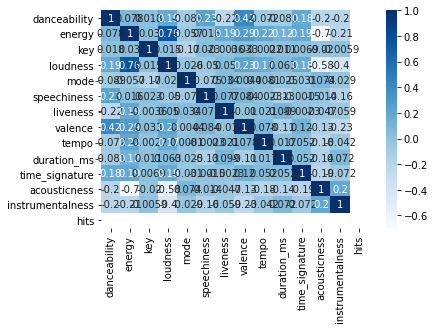

In [ ]:
sns.heatmap(subset_flops.corr(), annot=True, cmap='Blues')
plt.show()

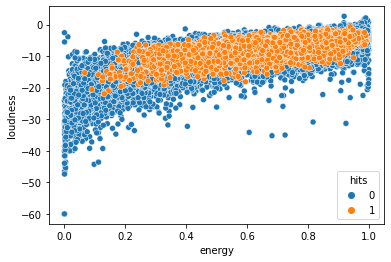

In [ ]:
data = pd.concat([subset_flops, df_hits])
sns.scatterplot(x=data['energy'], y=data['loudness'], hue=data['hits'])

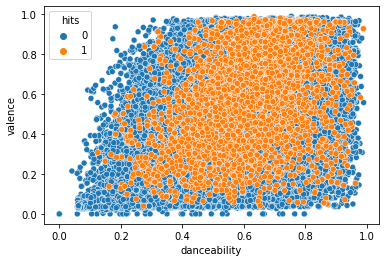

In [ ]:
sns.scatterplot(x=data['danceability'], y=data['valence'], hue=data['hits'])

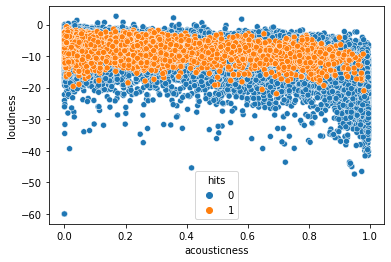

In [ ]:
sns.scatterplot(x=data['acousticness'], y=data['loudness'], hue=data['hits'])

In [9]:
cols = list(df.columns)[:-1]

X= df[cols]
y = df['hits']

In [10]:
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
print(np.count_nonzero(y==1))
print(np.count_nonzero(y==0))

503495
503495


In [ ]:
df['hits'].value_counts()

0    503495
1      2773
Name: hits, dtype: int64

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
#importing KNNClassifier
from sklearn.neighbors import KNeighborsClassifier

#creating model
KNN = KNeighborsClassifier()

#creating dictionary of parameters
n_neighbors = range(1, 21)
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'minkowski']
KNN_grid = dict(n_neighbors=n_neighbors, weights=weights, metric=metric)

#performing the RandomizedSearchCV
KNN_search = RandomizedSearchCV(KNN, KNN_grid, n_iter=50, scoring='precision', n_jobs=-1, cv=3, random_state=42)
KNN_result = KNN_search.fit(X_train,y_train)

#printing best results, and then all other results
print("Best: %f using %s" % (KNN_result.best_score_, KNN_result.best_params_))
KNN_means = KNN_result.cv_results_['mean_test_score']
KNN_stds = KNN_result.cv_results_['std_test_score']
KNN_params = KNN_result.cv_results_['params']

for mean, stdev, param in zip(KNN_means, KNN_stds, KNN_params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best: 0.902085 using {'weights': 'uniform', 'n_neighbors': 2, 'metric': 'manhattan'}
0.833931 (0.000790) with: {'weights': 'uniform', 'n_neighbors': 3, 'metric': 'manhattan'}
0.855518 (0.000936) with: {'weights': 'distance', 'n_neighbors': 4, 'metric': 'manhattan'}
0.822344 (0.000585) with: {'weights': 'uniform', 'n_neighbors': 3, 'metric': 'euclidean'}
0.836581 (0.001184) with: {'weights': 'distance', 'n_neighbors': 8, 'metric': 'manhattan'}
0.774586 (0.001138) with: {'weights': 'uniform', 'n_neighbors': 14, 'metric': 'euclidean'}
0.776382 (0.000835) with: {'weights': 'uniform', 'n_neighbors': 13, 'metric': 'manhattan'}
0.817163 (0.001080) with: {'weights': 'distance', 'n_neighbors': 17, 'metric': 'manhattan'}
0.818951 (0.000838) with: {'weights': 'uniform', 'n_neighbors': 6, 'metric': 'euclidean'}
0.872254 (0.001143) with: {'weights': 'uniform', 'n_neighbors': 1, 'metric': 'manhattan'}
0.812776 (0.000864) with: {'weights': 'distance', 'n_neighbors': 14, 'metric': 'minkowski'}
0.79050

In [ ]:
#importing the Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

#Creating the Model
forest=RandomForestClassifier()

#creating dictionary of parameters
n_estimators = [100, 300, 500, 800, 1200]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10] 
hyperparams = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

#performing a GridSearch
grid_forest = RandomizedSearchCV(forest, hyperparams, cv = 3, verbose = 1, 
                      n_jobs = -1, scoring='precision')

#fitting the model
bestF = grid_forest.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 444.7min finished


In [ ]:
#printing results
print("Best: %f using %s" % (bestF.best_score_, bestF.best_params_))
bestF_means = bestF.cv_results_['mean_test_score']
bestF_stds = bestF.cv_results_['std_test_score']
bestF_params = bestF.cv_results_['params']

for mean, stdev, param in zip(bestF_means, bestF_stds, bestF_params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.937400 using {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 25}
0.798048 (0.000290) with: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_depth': 8}
0.937162 (0.002538) with: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_depth': 25}
0.759313 (0.001051) with: {'n_estimators': 1200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 5}
0.757677 (0.002025) with: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_depth': 5}
0.936165 (0.001491) with: {'n_estimators': 1200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 25}
0.936620 (0.001150) with: {'n_estimators': 1200, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_depth': 25}
0.867807 (0.001516) with: {'n_estimators': 100, 'min_samples_split': 100, 'min_samples_leaf': 1, 'max_depth': 15}
0.798581 (0.000480) with: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_de

In [ ]:
best_clf = RandomForestClassifier(n_estimators=100, min_samples_split=5, min_samples_leaf=2, max_depth=25)
best_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=25, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
y_pred = best_clf.predict(X_test)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred, labels=[0,1])

array([[47203,  3137],
       [  284, 50075]])

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

0.9660274679986892
0.9410471322258137
0.9943604916698108
0.9669695184945593


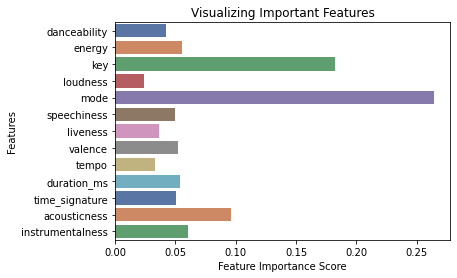

In [ ]:
#creating a plot to show how the features are 'weighted' by the model

feature_imp = pd.Series(best_clf.feature_importances_, index=cols)
sns.barplot(x=feature_imp, y = feature_imp.index, palette='deep')
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Visualizing Important Features")
plt.show()

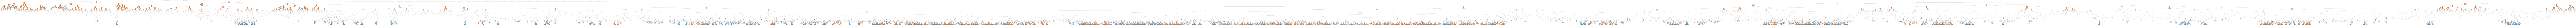

In [ ]:
#creating and saving a visuzalition of the Random Forest
estimator = best_clf.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = cols,
                class_names = "hit",
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')



In [12]:
!pip install tensorflow_decision_forests

     |████████████████████████████████| 6.2MB 4.0MB/s 


In [13]:
import tensorflow_decision_forests as tfdf

train_df, test_df = train_test_split(df, test_size=.2, random_state=42, shuffle=True)

train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label='hits')
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df, label='hits')

In [14]:
model = tfdf.keras.RandomForestModel()
model.compile(metrics=['precision'])
model.fit(train_ds)

6329/6329 [==============================] - 13s 1ms/step


In [15]:
model.summary()

Model: "random_forest_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (13):
	acousticness
	danceability
	duration_ms
	energy
	instrumentalness
	key
	liveness
	loudness
	mode
	speechiness
	tempo
	time_signature
	valence

No weights

Variable Importance: NUM_NODES:
    1.            "tempo" 21807.000000 ################
    2.         "loudness" 21640.000000 ###############
    3.         "liveness" 20832.000000 ###############
    4.      "speechiness" 20663.000000 ###############
    5.      "duration_ms" 20557.000000 ###############
    6.     "acousticness" 20434.000000 ##############
    7.          "valence" 20279.000000 ##############
    8.     "danceability" 19905.000000 ##############
    9